# Selection of Study Region

This notebook is used to defined the study region for the project. 

The study region was selected based on this criteria:
1. State of New York
2. HUC-6 (6 digits) basin
3. Should have included at least onde of the counties: Uslter, Orange, Delware, Sullivan, Greene

In [40]:
# Import packages
import geopandas as gpd
from pathlib import Path
from plotnine import *
import json
import pandas as pd

In [3]:
# File paths
project_base_path = Path.cwd().parent.parent 
shapefiles_base_path = project_base_path / 'data'/'shapefiles'
us_county_path = shapefiles_base_path / 'tl_2024_us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'tl_2024_us_state' / 'tl_2024_us_state.shp'

In [4]:
# Load files
us_state = gpd.read_file(us_state_path)
us_county = gpd.read_file(us_county_path)

In [5]:
# Selecting states
states_to_keep = ['New York', 'Pennsylvania', 'Connecticut', 'Massachusetts', 'Vermont']
us_eastern = us_state[us_state['NAME'].isin(states_to_keep)]
us_eastern.shape

(5, 16)

## Selecting the State of New York

In order to download the watershed shapefile, it is necessary to provide the boundary box of required region

C:\Users\esanttos\AppData\Local\Temp\ipykernel_10768\151164394.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

c:\Users\esanttos\Documents\Alan temp\Unit-hydrograph-Model\venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\esanttos\AppData\Local\Temp\ipykernel_10768\151164394.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

c:\Users\esanttos\Documents\Alan temp\Unit-hydrograph-Model\venv\Lib\site-packages\geopan

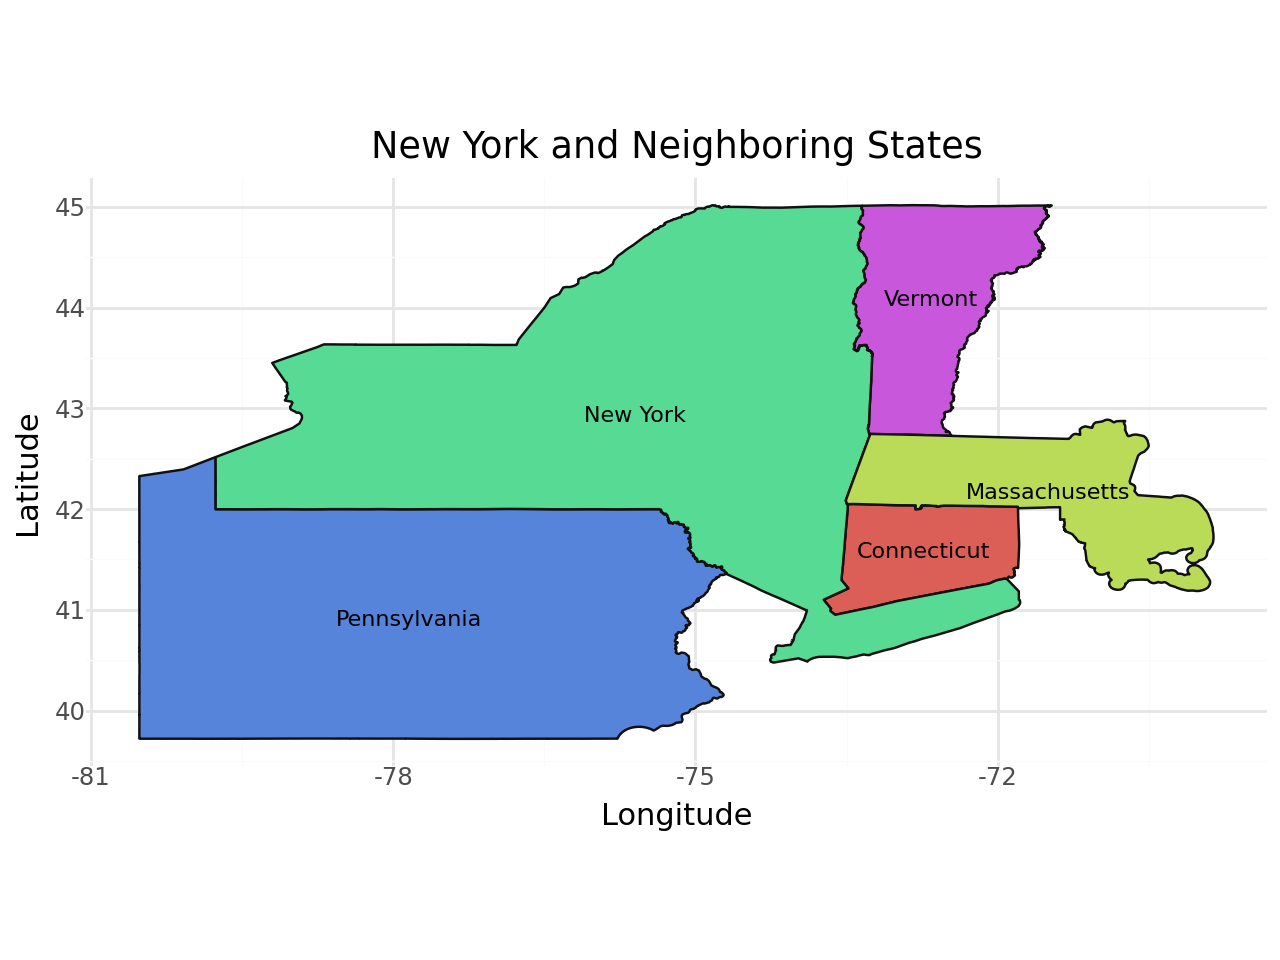

In [ ]:
# Define the centroid of each polygon
us_eastern["lon"] = us_eastern.geometry.centroid.x
us_eastern["lat"] = us_eastern.geometry.centroid.y


us_eastern_map = (
    ggplot(us_eastern)
    + geom_map(
        mapping=aes(fill="NAME", geometry="geometry"),
        data=us_eastern,
        inherit_aes=False
    )
    + geom_text(
        mapping=aes(x="lon", y="lat", label="NAME"),
        size=8,
        color="black"
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York and Neighboring States", x="Longitude", y="Latitude")
)

us_eastern_map

In [48]:
# Boundary box
minx, miny, maxx, maxy =  (us_eastern.unary_union).bounds

bottom_left = (minx, miny)
bottom_right = (maxx, miny)
top_right = (maxx, maxy)
top_left = (minx, maxy)

bbox = dict(bottom_left = bottom_left, bottom_right = bottom_right, top_right=top_right, top_left=top_left)

# Export in Json format
with open(project_base_path / 'data' / 'other' / 'ny_neighboring_bbox.json', 'w') as f:
    json.dump(bbox, f, indent=4)

C:\Users\esanttos\AppData\Local\Temp\ipykernel_4908\1018381951.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


## Selection of subbasin

In [30]:
WB_01_HU2_U2_path = shapefiles_base_path / 'WBD_01_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_02_HU2_U2_path = shapefiles_base_path / 'WBD_02_HU2_Shape' / 'Shape' / 'WBDHU2.shp'
WB_04_HU2_U2_path = shapefiles_base_path / 'WBD_04_HU2_Shape' / 'Shape' / 'WBDHU2.shp'

# Load Watershed Boundaries
WB_01_HU2_U2 = gpd.read_file(WB_01_HU2_U2_path)
WB_02_HU2_U2 = gpd.read_file(WB_02_HU2_U2_path)
WB_04_HU2_U2 = gpd.read_file(WB_04_HU2_U2_path)

# us_county = gpd.read_file(us_county_path)

C:\Users\esanttos\AppData\Local\Temp\ipykernel_10768\3197961360.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\esanttos\AppData\Local\Temp\ipykernel_10768\3197961360.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
C:\Users\esanttos\AppData\Local\Temp\ipykernel_10768\3197961360.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

C:\Users\esanttos\AppData\Local\Temp\ipykernel_10768\3197961360.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


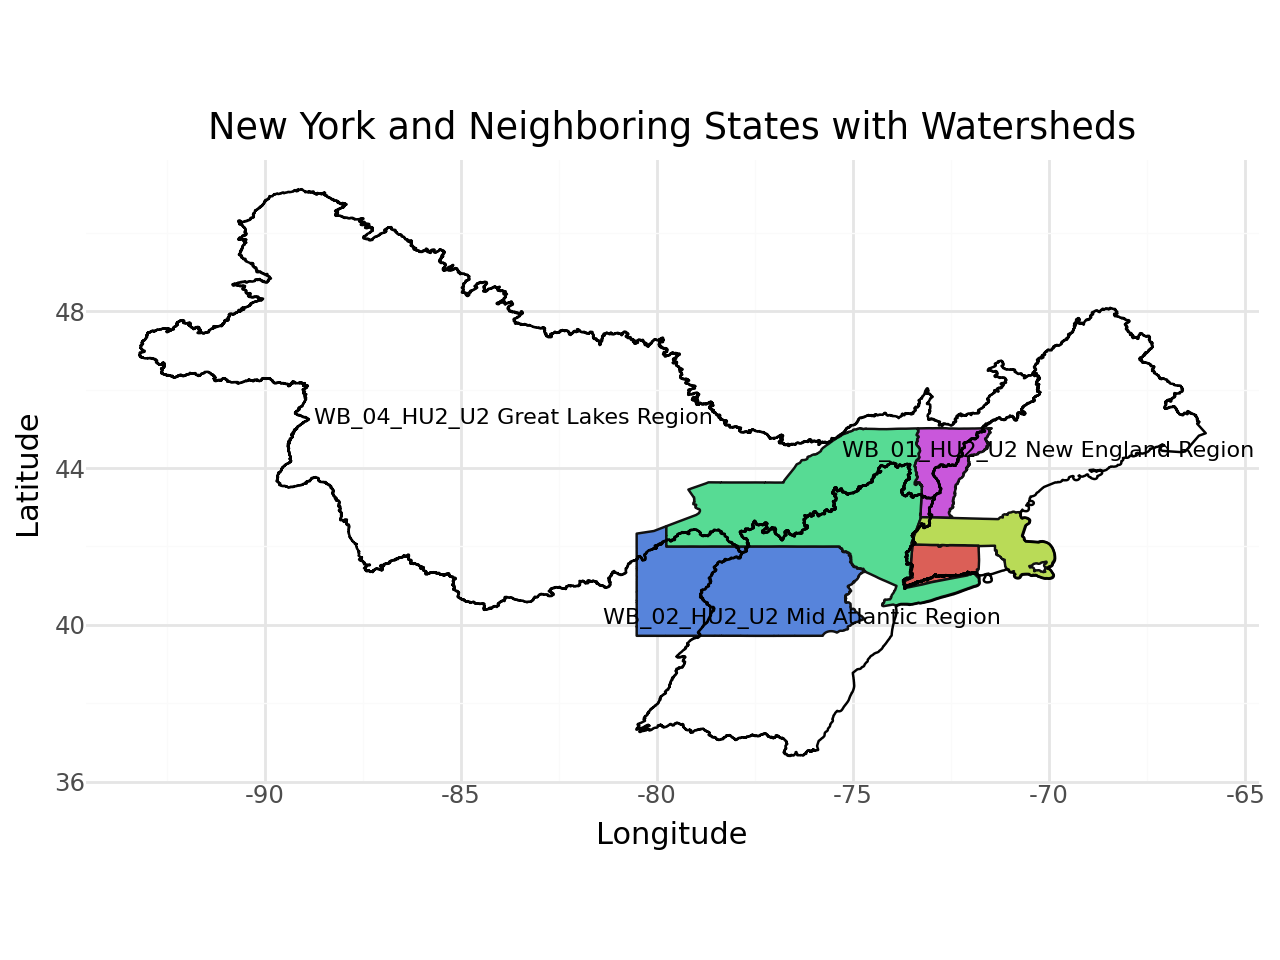

In [ ]:
# Dictionary mapping object names to the objects
WB_objects = {
    "WB_01_HU2_U2": WB_01_HU2_U2,
    "WB_02_HU2_U2": WB_02_HU2_U2,
    "WB_04_HU2_U2": WB_04_HU2_U2
}

# Create the DataFrame
WB_HU2_DESC = pd.DataFrame({
    'lon': [float(source.geometry.centroid.x) for source in WB_objects.values()],
    'lat': [float(source.geometry.centroid.y) for source in WB_objects.values()],
    'desc': [f"{name} {source['name'].iloc[0]}" for name, source in WB_objects.items()]
})


sub_basin_map = (
    ggplot(us_eastern)
    + geom_map(
        mapping=aes(fill="NAME", geometry="geometry"),
        data=us_eastern,
        inherit_aes=False
    )
    + coord_fixed()
    + theme_minimal()
    + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
    + labs(title="New York and Neighboring States with Watersheds", x="Longitude", y="Latitude")
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_01_HU2_U2,
        inherit_aes=False,
        color='black',
        fill=None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_02_HU2_U2,
        inherit_aes=False,
        color='black',
        fill=None
    )
    + geom_map(
        mapping=aes(geometry="geometry"),
        data=WB_04_HU2_U2,
        inherit_aes=False,
        color='black',
        fill=None
    )
    + geom_text(
        mapping=aes(x='lon', y="lat", label='desc'),
        data=WB_HU2_DESC,
        inherit_aes=False,
        size=8,
        color="black"
    )
)
sub_basin_map
